# Titanic Survival Analysis

### Data Prep - Read in and Inspect Training data


In [25]:
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import confusion_matrix,  roc_auc_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

df=pd.read_csv('C:/Training/Python/Titanic/train.csv')

#Drop columns not used
df=df.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)

print(df.head(5), "\n")
df.info()

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


### Quick Data Overview - Frequency table and percent churn

In [26]:
print(df['Sex'].value_counts(), "\n")
print(round(df.Survived.mean(),2),"% died")

male      577
female    314
Name: Sex, dtype: int64 

0.38 % died


### Missing Value Analysis and Imputation

In [27]:
print(df[df.dtypes.index].isnull().sum())


#Replace missing values for Embarked and Age
df["Embarked"] = df["Embarked"].fillna("S")
df['Age']=df["Age"].fillna(round(df['Age'].mean()))


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


### Prep character Variables

In [28]:
df = pd.concat([df, pd.get_dummies(df['Sex'], drop_first=True)], axis=1) #Drop_first k-1 levels #Female is now baseline
df = pd.concat([df, pd.get_dummies(df['Embarked'], drop_first=True)], axis=1) #C is now baseline
print(df.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  male    Q  \
0         0       3    male  22.0      1      0   7.2500        S   1.0  0.0   
1         1       1  female  38.0      1      0  71.2833        C   0.0  0.0   
2         1       3  female  26.0      0      0   7.9250        S   0.0  0.0   
3         1       1  female  35.0      1      0  53.1000        S   0.0  0.0   
4         0       3    male  35.0      0      0   8.0500        S   1.0  0.0   

     S  
0  1.0  
1  0.0  
2  1.0  
3  1.0  
4  1.0  


### Split into Training and Validation

In [29]:
df2=df.sample(frac=.7)
df_validation=df.loc[~df.index.isin(df2.index)]
df=df2


print(len(df.Age.values))
print(len(df_validation.Age.values))
print(df.head())

624
267
     Survived  Pclass     Sex   Age  SibSp  Parch    Fare Embarked  male    Q  \
68          1       3  female  17.0      4      2  7.9250        S   0.0  0.0   
465         0       3    male  38.0      0      0  7.0500        S   1.0  0.0   
872         0       1    male  33.0      0      0  5.0000        S   1.0  0.0   
321         0       3    male  27.0      0      0  7.8958        S   1.0  0.0   
488         0       3    male  30.0      0      0  8.0500        S   1.0  0.0   

       S  
68   1.0  
465  1.0  
872  1.0  
321  1.0  
488  1.0  


###  Build Linear Regression

In [30]:
%%capture 
#Suppress output

#Different Parts
Y = df.Survived.values
Features_train = df[['Pclass','SibSp','Parch','Fare','male','Q','S','Age']].values
Features_validation=df_validation[['Pclass','SibSp','Parch','Fare','male','Q','S','Age']].values

#Build Models
regression = linear_model.LogisticRegression(C=1)
regression.fit(Features_train,Y)

#see head of Y
print(Y[0:10])


### Score Linear Regression

In [31]:
#%%capture
#Supress output

#Make Predictions
predict_train = regression.predict_proba(Features_train)[:,1]
predict_validation = regression.predict_proba(Features_validation)[:,1]

#Append to dataset, classify >.49
df['predictions'] = (predict_train>.50).astype(float)
df_validation['predictions'] = (predict_validation>.50).astype(float)
print(df_validation.head())

    Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  male    Q  \
1          1       1  female  38.0      1      0  71.2833        C   0.0  0.0   
5          0       3    male  30.0      0      0   8.4583        Q   1.0  1.0   
10         1       3  female   4.0      1      1  16.7000        S   0.0  0.0   
12         0       3    male  20.0      0      0   8.0500        S   1.0  0.0   
16         0       3    male   2.0      4      1  29.1250        Q   1.0  1.0   

      S  predictions  
1   0.0          1.0  
5   0.0          0.0  
10  1.0          1.0  
12  1.0          0.0  
16  0.0          0.0  


### Confusion Matrices

In [32]:
#Confusion Matrix for Training
train_matrix=confusion_matrix(df.Survived.values, df.predictions.values)
print(train_matrix)
print('\n',100*round((train_matrix[0,0]+train_matrix[1,1])/len(df.Survived),3),"Accuracy - Logistic RR Train","\n")

#Confusion Matrix for Validation
validation_matrix=confusion_matrix(df_validation.Survived.values, df_validation.predictions.values)
print(validation_matrix)
print('\n',100*round((validation_matrix[0,0]+validation_matrix[1,1])/len(df_validation.Survived),3),"Auracy - LR Valid", "\n")


[[327  56]
 [ 78 163]]

 78.5 Accuracy - Logistic RR Train 

[[150  16]
 [ 31  70]]

 82.4 Auracy - LR Valid 



###  Build Gradient Boosting Model

In [33]:
gboost = GradientBoostingClassifier()
gboost.fit(Features_train, Y)

predict_train_gb = gboost.predict_proba(Features_train)[:,1]
predict_validation_gb = gboost.predict_proba(Features_validation)[:,1]


### Results

In [34]:
train_matrix=confusion_matrix(df.Survived.values, (predict_train_gb>.49).astype(float))
print(train_matrix)
print('\n',100*round((train_matrix[0,0]+train_matrix[1,1])/len(df.Survived),3),"Accuracy- GB Train","\n")

#Confusion Matrix for Validation
validation_matrix=confusion_matrix(df_validation.Survived.values, (predict_validation_gb>.49).astype(float))
print(validation_matrix)
print('\n',100*round((validation_matrix[0,0]+validation_matrix[1,1])/len(df_validation.Survived),3),"Accuracy - GB Validation")



[[366  17]
 [ 43 198]]

 90.4 Accuracy- GB Train 

[[156  10]
 [ 29  72]]

 85.4 Accuracy - GB Validation


### Score Test, Unseen data

#### Load in and Manipulate

In [35]:
df_test=pd.read_csv('C:/Training/Python/Titanic/test.csv')

#Drop columns not used
df_test=df_test.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)

#Missingness
print(df_test[df_test.dtypes.index].isnull().sum())
df_test["Age"]=df_test["Age"].fillna(round(df_test['Age'].mean()))
df_test["Fare"]=df_test["Fare"].fillna(round(df_test['Fare'].mean()))


#Validation
df_test = pd.concat([df_test, pd.get_dummies(df_test['Sex'], drop_first=True)], axis=1) 
df_test = pd.concat([df_test, pd.get_dummies(df_test['Embarked'], drop_first=True)], axis=1) 


Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


In [36]:
#Features to Predict
Features_predict=df_test[['Pclass','SibSp','Parch','Fare','male','Q','S','Age']].values

df_test['Survived_log'] = (regression.predict_proba(Features_predict)[:,1] > .49).astype(float)
df_test['Survived_gb'] = (gboost.predict_proba(Features_predict)[:,1] > .50).astype(float)

print(df_test.head())


   Pclass     Sex   Age  SibSp  Parch     Fare Embarked  male    Q    S  \
0       3    male  34.5      0      0   7.8292        Q   1.0  1.0  0.0   
1       3  female  47.0      1      0   7.0000        S   0.0  0.0  1.0   
2       2    male  62.0      0      0   9.6875        Q   1.0  1.0  0.0   
3       3    male  27.0      0      0   8.6625        S   1.0  0.0  1.0   
4       3  female  22.0      1      1  12.2875        S   0.0  0.0  1.0   

   Survived_log  Survived_gb  
0           0.0          0.0  
1           0.0          0.0  
2           0.0          0.0  
3           0.0          0.0  
4           1.0          0.0  


In [37]:
print(confusion_matrix(df_test['Survived_log'].values, df_test['Survived_gb'].values))

[[249  17]
 [ 28 124]]


### Write to CSV

In [38]:
#df_test.to_csv('C:/Training/Python/Titanic/Results/Python_Predictions.csv')

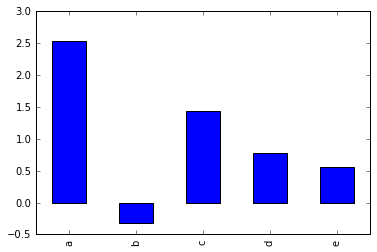

In [39]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt
c=pd.Series(np.random.randn(5), index=['a', 'b', 'c', 'd', 'e'])
import matplotlib.pyplot as plt
c.plot(kind='bar')
#plt.show()


### Create Roc Curve

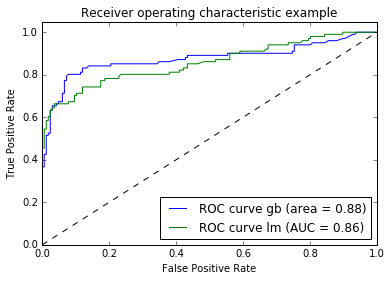

In [59]:
%matplotlib inline
fpr_gb, tpr_gb, thresholds_gb=roc_curve(df_validation.Survived, predict_validation_gb)
roc_gb=auc(fpr_gb,tpr_gb) #Another way to print the ROC score instead of roc_auc_score

fpr_lm, tpr_lm, thresholds_lm=roc_curve(df_validation.Survived, predict_validation)
roc_lm=auc(fpr_lm,tpr_lm)



#Plot your ROC Curve
plt.figure()
plt.plot(fpr_gb, tpr_gb, label='ROC curve gb (area = %0.2f)' % roc_gb)
plt.plot(fpr_lm, tpr_lm, label='ROC curve lm (AUC = %0.2f)' % roc_lm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
